In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import pingouin as pg

from statsmodels.stats.multicomp import pairwise_tukeyhsd


%matplotlib inline

In [3]:
### Load losses
base_loss = pd.read_pickle("./weights/elia-base-transformer-freqD-layers2-heads4-fe256_test_losses.pkl")
causal_loss = pd.read_pickle("./weights/elia-causal-conv-transformer-freqD-layers2-heads4-fe256-ks9_test_losses.pkl")
asym_loss = pd.read_pickle("./weights/elia-asym-conv-transformer-freqD-layers2-heads4-fe256-ks3_test_losses.pkl")
fourier_loss = pd.read_pickle("./weights/elia-fourier-transformer-freqD-layers2-heads4-fe256_test_losses.pkl")

base_loss = base_loss.squeeze().to_numpy()
causal_loss = causal_loss.squeeze().to_numpy()
asym_loss = asym_loss.squeeze().to_numpy()
fourier_loss = fourier_loss.squeeze().to_numpy()

df = pd.DataFrame({
    'loss': pd.concat([pd.Series(base_loss), pd.Series(causal_loss), pd.Series(asym_loss), pd.Series(fourier_loss)], ignore_index=True),
    'group': ['base']*len(base_loss) + ['causal']*len(causal_loss) + ['asym']*len(asym_loss) + ['fourier']*len(fourier_loss)
})

### ANOVA Assumptions
#### Normality

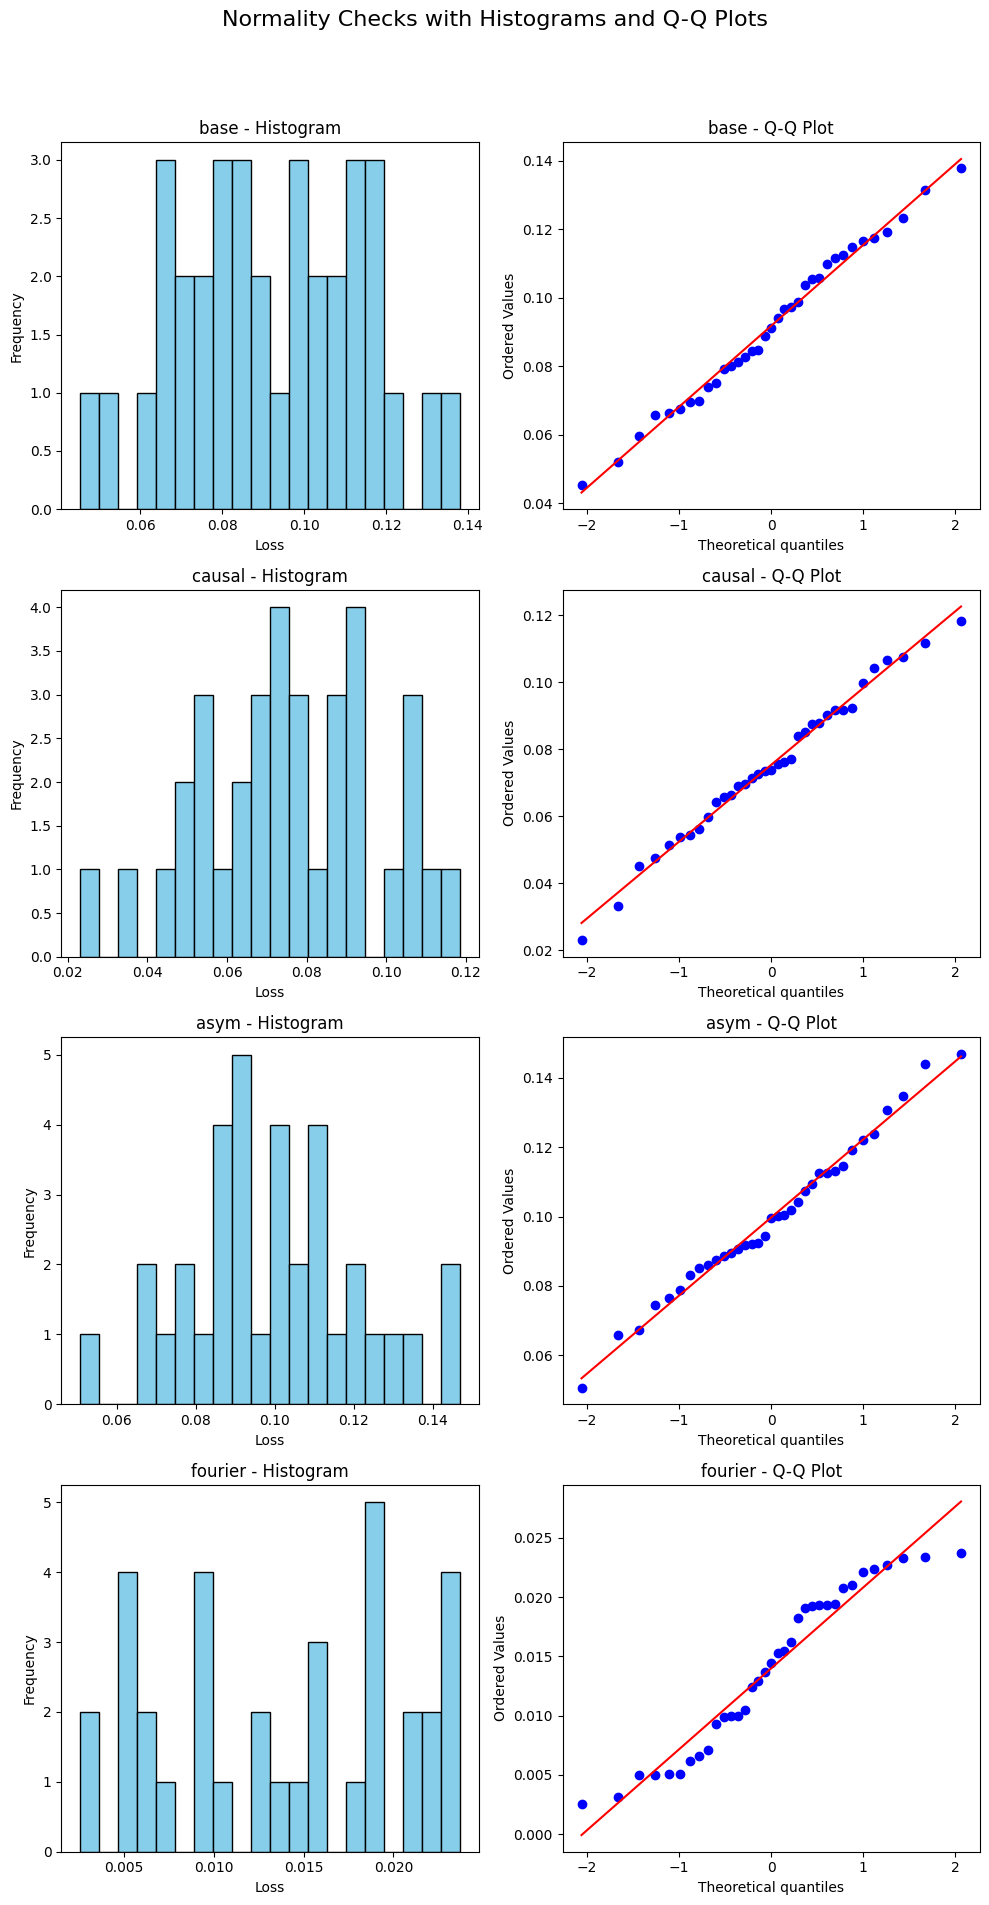

In [4]:
groups = df['group'].unique()

fig, axes = plt.subplots(nrows=len(groups), ncols=2, figsize=(10, len(groups)*5))
fig.suptitle('Normality Checks with Histograms and Q-Q Plots', fontsize=16)

for i, group in enumerate(groups):
    data = df[df['group'] == group]['loss']

    axes[i, 0].hist(data, bins=20, color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'{group} - Histogram')
    axes[i, 0].set_xlabel('Loss')
    axes[i, 0].set_ylabel('Frequency')

    stats.probplot(data, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'{group} - Q-Q Plot')
    axes[i, 1].get_lines()[1].set_color('red')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./graphs/qq_plots.png")
plt.show()

In [5]:
#H_0: data was drawn from a normal distribution.
print("Normality Test Results:")
for group in df['group'].unique():
    stat, p = stats.shapiro(df[df['group'] == group]['loss'])
    print(f"{group}: Statistics={stat}, p-value={p}")

Normality Test Results:
base: Statistics=0.9849889874458313, p-value=0.9036503434181213
causal: Statistics=0.9885133504867554, p-value=0.9686439633369446
asym: Statistics=0.9879127740859985, p-value=0.9603567719459534
fourier: Statistics=0.9269781708717346, p-value=0.02276924066245556


#### Homogeneity of Variances

In [6]:
#H_0: all input samples are from populations with equal variances.
print("\nHomogeneity of Variances Test (Levene's Test):")
stat, p = stats.levene(df[df['group'] == 'base']['loss'],
                       df[df['group'] == 'causal']['loss'],
                       df[df['group'] == 'asym']['loss'],
                       df[df['group'] == 'fourier']['loss'])
print(f"Statistics={stat}, p-value={p}")


Homogeneity of Variances Test (Levene's Test):
Statistics=9.98810722340771, p-value=5.403487376474435e-06


### (one-way) Welch's ANOVA Test

In [8]:
#H_0: two or more groups have the same population mean.
print("\nWelch's ANOVA test:")
pg.welch_anova(data=df, dv='loss', between='group')


Welch's ANOVA test:


,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,64.651136,310.770539,2.466097e-38,0.751061


### Post Hoc Tukey HSD Test

In [9]:
#H_0: all means being compared are from the same population
tukey = pairwise_tukeyhsd(endog=df['loss'], groups=df['group'], alpha=0.05)
print("\nTukey HSD Test Results:")
print(tukey.summary())


Tukey HSD Test Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
  asym    base  -0.0079  0.332 -0.0202  0.0043  False
  asym  causal  -0.0243    0.0 -0.0366 -0.0121   True
  asym fourier  -0.0858    0.0  -0.098 -0.0735   True
  base  causal  -0.0164 0.0036 -0.0286 -0.0042   True
  base fourier  -0.0778    0.0   -0.09 -0.0656   True
causal fourier  -0.0614    0.0 -0.0737 -0.0492   True
-----------------------------------------------------
